# Nan Value Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels .api as sm
from sklearn.preprocessing import StandardScaler
import ISLP

In [2]:
test_data = pd.read_csv("C:\\Users\\Administrator\\Desktop\\STA 141C\\test.csv")
train_data = pd.read_csv("C:\\Users\\Administrator\\Desktop\\STA 141C\\train.csv")
test_df = pd.DataFrame(test_data)
train_df = pd.DataFrame(train_data)
#print(train_df.columns)
print(train_df.shape)
missing_counts = train_df.isna().sum()
missing_pct = missing_counts / len(train_df) * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPct': missing_pct
})
missing_df = missing_df[missing_df['MissingCount'] > 0].sort_values('MissingPct', ascending=False)
missing_df.head(10)

(1460, 81)


,MissingCount,MissingPct
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


## Handling NaN Values in Pool-Related Features

PoolQC and PoolArea are two features related to swimming pools in the dataset. The PoolArea feature indicates the area of the pool, while PoolQC provides a quality rating for the pool. However, both features are incredibly sparse: only 7 homes out of 1 460 have a pool.

Steps taken to handle these features:

- Created binary flag feature **HasPool** to indicate whether a house has a pool or not.  
- Created an ordinal variable **PoolQC_ord** to represent the quality of the pool on a scale from 0 to 4 (NaN → 0).  
- Created an interaction feature **PoolQualityArea** to capture the relationship between pool quality and area.  
- Created a binary feature **PoolHighPriceOutlier** to identify the single pool home in the top 0.1 % of sale prices. **This house is a potential outlier and may need special handling in the analysis.**  
- Ensured that the cross-validation folds do not end up with all 7 entries of **HasPool** in the same fold, which could lead to biased results.  
- Used **LOOCV (Leave-One-Out Cross-Validation)**—with stratification on **HasPool**—to evaluate the model performance with and without the pool-related features.

**Conclusion:**  
- The only pool-derived feature that consistently improves upon the intercept-only model is the **PoolHighPriceOutlier × PoolArea** interaction; the outlier flag alone also yields a small gain.  
- All other pool features—PoolQC, PoolArea, PoolQualityArea, HasPool, and the remaining interaction terms—degrade or fail to improve performance under LOOCV.  
- Drop `PoolQC`, `PoolArea`, `PoolQualityArea`, `HasPool`, and the unused interactions from the modeling set. Retain only the `PoolHighPriceOutlier` and `PoolArea` feature for predictive modeling. 


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

df = train_df.copy()
df['HasPool'] = (df['PoolArea'] > 0).astype(int)
quality_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1}
df['PoolQC_ord'] = df['PoolQC'].map(quality_map).fillna(0).astype(int)
df['PoolArea_GrLivArea'] = df['PoolArea'] * df['GrLivArea']
df['PoolArea_OverallQual'] = df['PoolArea'] * df['OverallQual']
df['PoolQualityArea'] = df['PoolArea'] * df['PoolQC_ord']
high_price_cut = df['SalePrice'].quantile(0.999)
df['PoolHighPriceOutlier'] = ((df['HasPool'] == 1) & (df['SalePrice'] > high_price_cut)).astype(int)

feature_sets = [
    ('Intercept only', None),
    ('PoolArea', ['PoolArea']),
    ('HasPool', ['HasPool']),
    ('PoolQC_ord', ['PoolQC_ord']),
    ('PoolQualityArea', ['PoolQualityArea']),
    ('PoolHighPriceOutlier', ['PoolHighPriceOutlier']),
    ('All basic pool', ['PoolArea', 'HasPool', 'PoolQC_ord']),
    ('Pool + Outlier', ['PoolArea', 'PoolHighPriceOutlier']),
    ('All pool + interactions', [
        'PoolArea', 'HasPool', 'PoolQC_ord',
        'PoolArea_GrLivArea', 'PoolArea_OverallQual',
        'PoolQualityArea', 'PoolHighPriceOutlier'
    ])
]

loo = LeaveOneOut()
y = df['SalePrice'].values
results = []

for name, cols in feature_sets:
    if cols is None:
        X = np.ones((len(df), 1))
    else:
        X = df[cols].values
    sq_errors = []
    for train_idx, test_idx in loo.split(X):
        model = LinearRegression()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        # Compute squared log-error
        sq_errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)
    log_rmse = np.sqrt(np.mean(sq_errors))
    results.append((name, log_rmse))

res_df = pd.DataFrame(results, columns=['Model', 'LOO Log RMSE']).sort_values('LOO Log RMSE')
print(res_df.to_string(index=False))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13932\171100361.py:47: RuntimeWarning: invalid value encountered in log
  sq_errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13932\171100361.py:47: RuntimeWarning: invalid value encountered in log
  sq_errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13932\171100361.py:47: RuntimeWarning: invalid value encountered in log
  sq_errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13932\171100361.py:47: RuntimeWarning: invalid value encountered in log
  sq_errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)


                  Model  LOO Log RMSE
         Pool + Outlier      0.406918
   PoolHighPriceOutlier      0.407452
        PoolQualityArea      0.407529
               PoolArea      0.407534
                HasPool      0.407596
             PoolQC_ord      0.407658
         Intercept only      0.407880
         All basic pool      0.416191
All pool + interactions           NaN


In [4]:
df['PoolOutlierArea'] = df['PoolArea'] * df['PoolHighPriceOutlier']
drop_cols = [
    'HasPool',
    'PoolArea',
    'PoolQC_ord',
    'PoolQualityArea',
    'PoolArea_GrLivArea',
    'PoolArea_OverallQual',
    'PoolHighPriceOutlier',
    'PoolQC'
]
df.drop(columns=drop_cols, errors='ignore', inplace=True)

df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Handling NaN Values in MiscFeature

MiscFeature records rare amenities like elevator, second garage, tennis court or shed, but most homes (around 96%) have no entry.

Steps taken:

- Fill missing values with “None” so every home falls into one category.
- Create a binary flag HasMisc to indicate whether any miscellaneous feature exists.
- Create a count variable MiscCount to record how many non-None misc features each home has.
- Create an interaction term HasMisc × MiscCount to test combined effect.
- Try one-hot encoding each category, but with so few examples per level it led to unstable models.
- Use Leave-One-Out CV with log RMSE (root-mean-square error of log-predicted vs log-actual sale price) as the evaluation metric to compare:
  - intercept-only  
  - HasMisc alone  
  - MiscCount alone  
  - HasMisc + MiscCount  
  - HasMisc × MiscCount  
  - one-hot variants  
  - full combined model  

Conclusion:
- HasMisc, MiscCount, and their interaction all achieve the same best log RMSE. We choose to keep HasMisc and MiscCount together because they capture both presence and quantity of features without redundant interaction and are simple to interpret. 
- Replace the original MiscFeature column with HasMisc and MiscCount in the modeling pipeline.


In [5]:
misc = df['MiscFeature'].fillna('None')
df['HasMisc'] = (misc != 'None').astype(int)

dummies = pd.get_dummies(misc, prefix='Misc')
dummies = dummies.drop(columns=[col for col in dummies.columns if col.endswith('_None')], errors='ignore')

df['MiscCount'] = dummies.sum(axis=1)
df['HasMisc_MiscCount'] = df['HasMisc'] * df['MiscCount']

feature_sets = [
    ('Intercept only', None),
    ('HasMisc', ['HasMisc']),
    ('MiscCount', ['MiscCount']),
    ('OneHotDummies', dummies),
    ('HasMisc + OneHotDummies', pd.concat([df[['HasMisc']], dummies], axis=1)),
    ('MiscCount + OneHotDummies', pd.concat([df[['MiscCount']], dummies], axis=1)),
    ('HasMisc + MiscCount', ['HasMisc', 'MiscCount']),
    ('HasMisc × MiscCount', ['HasMisc_MiscCount']),
    ('All combined', pd.concat([df[['HasMisc','MiscCount','HasMisc_MiscCount']], dummies], axis=1))
]

loo = LeaveOneOut()
y = df['SalePrice'].values
results = []

for name, feat in feature_sets:
    # Build X array
    if feat is None:
        X = np.ones((len(df), 1))
    elif isinstance(feat, pd.DataFrame):
        X = feat.values
    else:
        X = df[feat].values
    # LOOCV
    errors = []
    for train_idx, test_idx in loo.split(X):
        model = LinearRegression()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        # log RMSE
        errors.append((np.log(y_pred) - np.log(y[test_idx]))**2)
    rmse = np.sqrt(np.mean(errors))
    results.append((name, rmse))

res_df = pd.DataFrame(results, columns=['Model', 'LOO Log RMSE']).sort_values('LOO Log RMSE')
print(res_df.to_string(index=False))

df = df.drop(columns=['MiscFeature', 'HasMisc_MiscCount'], errors='ignore')


                    Model  LOO Log RMSE
                  HasMisc      0.406822
                MiscCount      0.406822
      HasMisc × MiscCount      0.406822
      HasMisc + MiscCount      0.406835
            OneHotDummies      0.407143
           Intercept only      0.407880
  HasMisc + OneHotDummies      0.866079
MiscCount + OneHotDummies      0.866079
             All combined      0.875955


In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
total_rows = len(df)
rows_with_nan = df.isna().any(axis=1).sum()
pct_with_nan = rows_with_nan / total_rows * 100

print(f"Total rows: {total_rows}")
print(f"Rows with at least one NaN: {rows_with_nan} ({pct_with_nan:.2f}%)\n")

missing_counts = df.isna().sum()
missing_pct = missing_counts / total_rows * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPct': missing_pct
})
missing_df = missing_df[missing_df['MissingCount'] > 0].sort_values('MissingPct', ascending=False)

print("Missing Value Summary:")
print(missing_df)


Total rows: 1460
Rows with at least one NaN: 1460 (100.00%)

Missing Value Summary:
              MissingCount  MissingPct
Alley                 1369   93.767123
Fence                 1179   80.753425
MasVnrType             872   59.726027
FireplaceQu            690   47.260274
LotFrontage            259   17.739726
GarageType              81    5.547945
GarageYrBlt             81    5.547945
GarageFinish            81    5.547945
GarageQual              81    5.547945
GarageCond              81    5.547945
BsmtExposure            38    2.602740
BsmtFinType2            38    2.602740
BsmtCond                37    2.534247
BsmtFinType1            37    2.534247
BsmtQual                37    2.534247
MasVnrArea               8    0.547945
Electrical               1    0.068493


In [8]:
df["Alley"].value_counts(dropna=False)

Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64

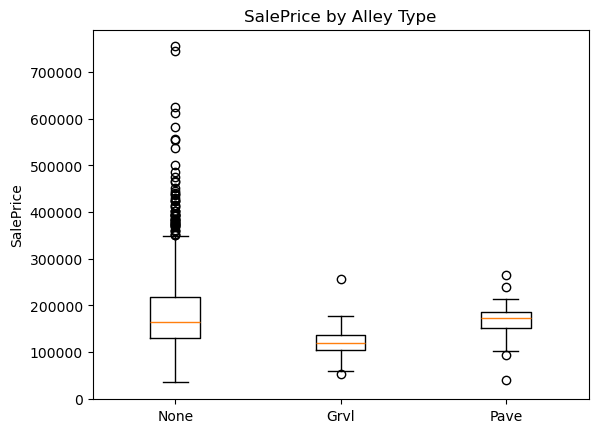

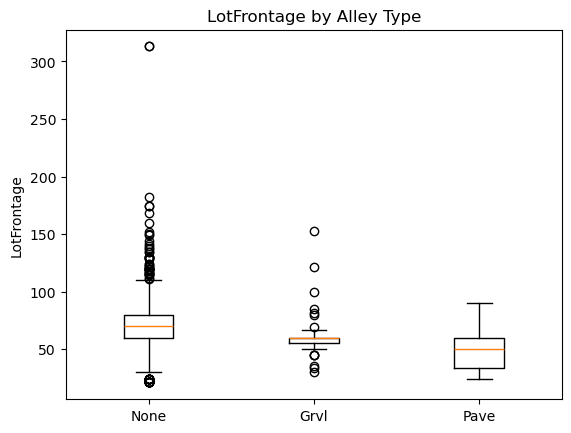

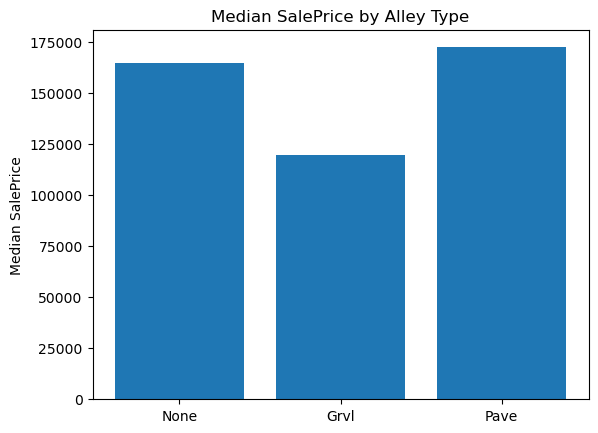

In [9]:
df['Alley_filled'] = df['Alley'].fillna('None')
cats = ['None', 'Grvl', 'Pave']

# 1. Boxplot: SalePrice by Alley type
price_data = [df.loc[df['Alley_filled'] == c, 'SalePrice'] for c in cats]
plt.figure()
plt.boxplot(price_data)
plt.xticks([1, 2, 3], cats)
plt.title('SalePrice by Alley Type')
plt.ylabel('SalePrice')
plt.show()

# 2. Boxplot: LotFrontage by Alley type
front_data = [df.loc[df['Alley_filled'] == c, 'LotFrontage'].dropna() for c in cats]
plt.figure()
plt.boxplot(front_data)
plt.xticks([1, 2, 3], cats)
plt.title('LotFrontage by Alley Type')
plt.ylabel('LotFrontage')
plt.show()

# 3. Bar chart: Median SalePrice by Alley type
meds = df.groupby('Alley_filled')['SalePrice'].median().reindex(cats)
plt.figure()
plt.bar(range(len(meds)), meds)
plt.xticks(range(len(meds)), cats)
plt.title('Median SalePrice by Alley Type')
plt.ylabel('Median SalePrice')
plt.show()


                     SalePrice  HasAlley  LotFrontage  Alley_x_LotFrontage
SalePrice             1.000000 -0.123611     0.351799            -0.118809
HasAlley             -0.123611  1.000000    -0.173249             0.909607
LotFrontage           0.351799 -0.173249     1.000000            -0.085820
Alley_x_LotFrontage  -0.118809  0.909607    -0.085820             1.000000


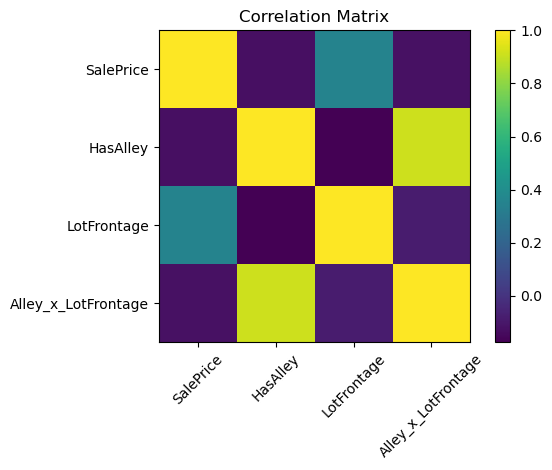

In [10]:
alley_map = {'None': 0, 'Grvl': 1, 'Pave': 2}
df['Alley_ord'] = df['Alley_filled'].map(alley_map).astype(int)
df['HasAlley'] = (df['Alley_filled'] != 'None').astype(int)
df['Alley_x_LotFrontage'] = df['HasAlley'] * df['LotFrontage'].fillna(0)

features = ['SalePrice', 'HasAlley', 'LotFrontage', 'Alley_x_LotFrontage']
corr_matrix = df[features].corr()

print(corr_matrix)

# 2. Plot heatmap of correlations
plt.figure()
plt.imshow(corr_matrix)
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=45)
plt.yticks(range(len(features)), features)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [11]:
X = df[['HasAlley','LotFrontage','Alley_x_LotFrontage']].fillna(0)
X = sm.add_constant(X)
y = df['SalePrice']
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     30.76
Date:                Thu, 29 May 2025   Prob (F-statistic):           2.80e-19
Time:                        15:23:07   Log-Likelihood:                -18499.
No. Observations:                1460   AIC:                         3.701e+04
Df Residuals:                    1456   BIC:                         3.703e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.551e+05   4

In [12]:
df['Alley_filled'].value_counts(dropna=False)

Alley_filled
None    1369
Grvl      50
Pave      41
Name: count, dtype: int64

In [13]:
df['Alley_ord'].value_counts(dropna=False)

Alley_ord
0    1369
1      50
2      41
Name: count, dtype: int64

In [14]:
df['HasAlley'].value_counts(dropna=False)

HasAlley
0    1369
1      91
Name: count, dtype: int64

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,PoolOutlierArea,HasMisc,MiscCount,Alley_filled,Alley_ord,HasAlley,Alley_x_LotFrontage
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,208500,0,0,0,None,0,0,0.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,181500,0,0,0,None,0,0,0.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,223500,0,0,0,None,0,0,0.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,WD,Abnorml,140000,0,0,0,None,0,0,0.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,250000,0,0,0,None,0,0,0.0


In [15]:

# Standardize only numerical columns
numerical_cols = df.select_dtypes(include='number').columns
df_standardized = df.copy()
df_standardized[numerical_cols] = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()


In [17]:
# Save the standardized DataFrame to a CSV file
df_standardized.to_csv('C:\\Users\\Administrator\\Desktop\\STA 141C\\standardized_data.csv', index=False)